# Setup
---
<br>
<br>
<br>
<br>
<br>


In [2]:
def setup(basedir=None):
    if basedir==None:
        basedir:str = "D:\Datasets\KITTI_cvlibs"
        
#             basedir = "/media/michaelkatsoulis/Data raw/Datasets/KITTI_cvlibs/"
    date = '2011_09_26'
#     drive = "0001"
    drive = "0113"
    return pykitti.raw(basedir, date, drive)
        

In [3]:
import cv2
import pykitti
import matplotlib.pylab as plt
import numpy as np
import time
import DelaunayTriangulate as dt
from pathlib import Path

from jupyterthemes import jtplot
jtplot.style()

%matplotlib notebook

im_fig_size=(15,5)

data = setup()

img_frame = 0
#     print(data.calib)
cam2_image, cam3_image = data.get_rgb(img_frame)
# imgL = cv2.imread(np.array(cam2_image), cv2.COLOR_RGB2BGR)
# imgR = cv2.cvtColor(np.array(cam3_image), cv2.COLOR_RGB2BGR)

imgL = np.array(cam2_image)
imgR = np.array(cam3_image)

lidar_data = data.get_velo(img_frame)

Text(0.5, 1.0, 'Lidar plot coloured by depth')

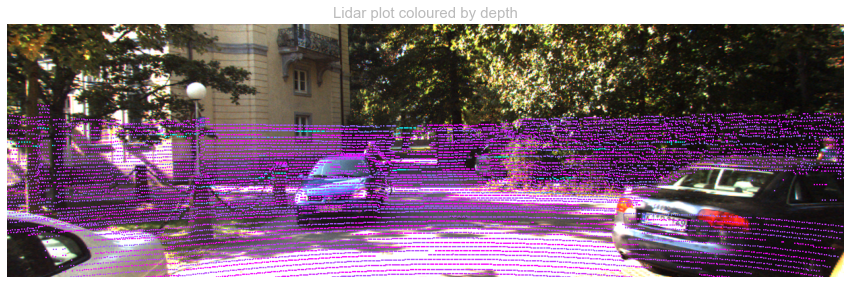

In [4]:
def pointcloud_to_image(pointcloud,img_height,img_width,Tr,P,useDepth=True):
    #     Trimming pointcloud for speedup
    pointcloud = pointcloud[pointcloud[:, 0] >
                            0]  #Everything in front of camera

    xyz = pointcloud[:, :3]
    reflectance = pointcloud[:, 3]

    #     making the pointcloud homogenous
    xyz = np.hstack((xyz, np.ones((xyz.shape[0], 1))))
    #     xyz now [ X, Y, Z, 1]

    #     transforming lidar into camera frame
    cam_xyz = Tr.dot(xyz.T).T
    lidar_depth = cam_xyz[:, 2].copy()  #Everything in front of camera
    cam_xyz = cam_xyz / cam_xyz[:, 2].reshape((-1, 1))

    img_xyz = P.dot(cam_xyz.T).T

    pixel_coords = img_xyz.round(0).astype(int)
    indicies = np.where((pixel_coords[:, 0] >= 0)
                        & (pixel_coords[:, 1] >= 0)
                        & (pixel_coords[:, 0] < imgL.shape[1])
                        & (pixel_coords[:, 1] < imgL.shape[0]))

    pixel_coords = pixel_coords[indicies]
    pixel_coords.max(axis=0)
    render = np.zeros((img_height, img_width))

    for j, (u, v) in enumerate(pixel_coords[:, :2]):
        if useDepth: render[v, u] = lidar_depth[j]
        else:
            render[v, u] = (reflectance[j] * 255).astype(int)

    return render

render_lidar = pointcloud_to_image(lidar_data, imgL.shape[0], imgL.shape[1], data.calib.T_cam2_velo, data.calib.P_rect_20)


%matplotlib inline

fig_l, ax_l = plt.subplots(1,1, figsize=im_fig_size)
kernel2=np.ones((2,2), np.uint8)
kernel3=np.ones((3,3), np.uint8)
dst = (255*(render_lidar.copy())/render_lidar.max()).astype(np.uint8)
dst = cv2.dilate(dst, kernel2, iterations=1)
inds = np.where(dst>0)
dst = cv2.applyColorMap(dst, cv2.COLORMAP_SPRING)

im_gray3 = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
im_gray3 = cv2.cvtColor(im_gray3, cv2.COLOR_GRAY2BGR)

# img_dist = im_gray3.copy()
img_dist = imgL.copy()
img_dist[inds] = dst[inds]

# ax_l[1].imshow(cv2.dilate(render_reflectance.copy(), kernel, iterations=1))
# ax_l[1].imshow(img_ref)
ax_l.imshow(img_dist)
ax_l.axis('off')
ax_l.set_title("Lidar plot coloured by depth",  fontsize=im_fig_size[0])

# LiDAR to Triangular meshes
---
<br>
<br>
<br>
<br>
<br>


In [5]:
def pointcloud_to_img_frame(pointcloud, img_height, img_width, Tr, P, useDepth=True):
    #     Trimming pointcloud for speedup
    pointcloud = pointcloud[pointcloud[:, 0] > 0].copy()  #Everything in front of camera

    xyz = pointcloud[:, :3]
    reflectance = pointcloud[:, 3]

    #     making the pointcloud homogenous
    xyz = np.hstack((xyz, np.ones((xyz.shape[0], 1))))
    #     xyz now [ X, Y, Z, 1]

    #     transforming lidar into camera frame
    cam_xyz = Tr.dot(xyz.T).T
#     lidar_depth = cam_xyz[:, 2].copy()  #Everything in front of camera
    cam_xyz = cam_xyz / cam_xyz[:, 2].reshape((-1, 1))

    img_xyz = P.dot(cam_xyz.T).T # image frame
    pixel_coords = img_xyz.round(0).astype(int)
    indicies = np.where((pixel_coords[:, 0] >= 0)
                        & (pixel_coords[:, 1] >= 0)
                        & (pixel_coords[:, 0] < imgL.shape[1])
                        & (pixel_coords[:, 1] < imgL.shape[0]))

#     pixel_coords = pixel_coords[indicies]
#     pixel_coords.max(axis=0)
#     render = np.zeros((img_height, img_width))

#     for j, (u, v) in enumerate(pixel_coords[:, :2]):
#         if useDepth: render[v, u] = lidar_depth[j]
#         else:
#             render[v, u] = (reflectance[j] * 255).astype(int)

    return xyz[indicies]

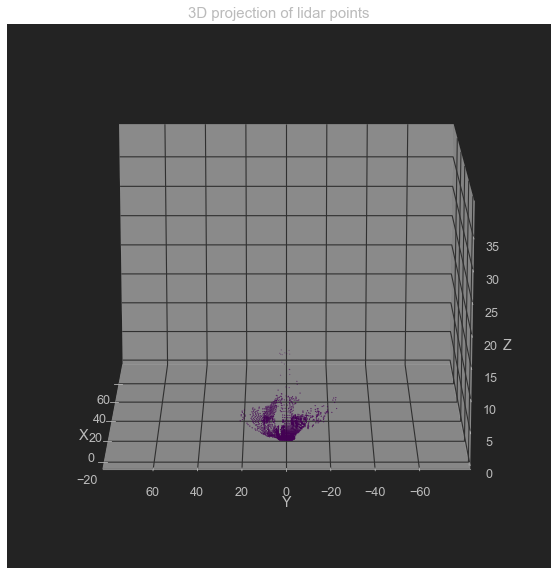

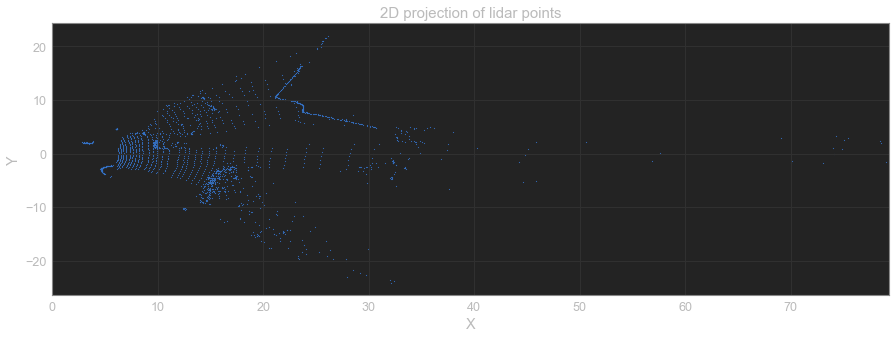

In [30]:
cropped_lidar = pointcloud_to_img_frame(lidar_data, imgL.shape[0], imgL.shape[1], data.calib.T_cam2_velo, data.calib.P_rect_20)



# %matplotlib notebook

fig_lc= plt.figure(figsize=[20,10])
cropped_lidar_subsampled = cropped_lidar[::10]
ax_lc = fig_lc.add_subplot(111, projection='3d')
ax_lc.scatter3D(cropped_lidar_subsampled[:,0], cropped_lidar_subsampled[:,1], cropped_lidar_subsampled[:,2],s=1, c=cropped_lidar_subsampled[:,3])
ax_lc.set_xlabel("X")
ax_lc.set_ylabel("Y")
ax_lc.set_zlabel("Z")


ax_lims = [cropped_lidar_subsampled.min(),cropped_lidar_subsampled.max()]
ax_lc.set_xlim(ax_lims)
ax_lc.set_ylim([-cropped_lidar_subsampled.max(),cropped_lidar_subsampled.max()])
ax_lc.set_zlim([0,cropped_lidar_subsampled.max()/2])
ax_lc.view_init(elev=15., azim=180)
ax_lc.set_title("3D projection of lidar points", fontsize=im_fig_size[0])

fig_lc_2d = plt.figure(figsize=im_fig_size)
ax_lc_2d = fig_lc_2d.add_subplot(111)
ax_lc_2d.scatter(cropped_lidar_subsampled[:,0], cropped_lidar_subsampled[:,1] ,s=1)#, c=cropped_lidar_subsampled[:,3])
ax_lc_2d.set_xlabel("X")
ax_lc_2d.set_ylabel("Y")
ax_lc_2d.set_xlim([0, cropped_lidar_subsampled[:,0].max()])
ax_lc_2d.set_title("2D projection of lidar points", fontsize=im_fig_size[0])


plt.show()

# Exploring Geometric Error in Sampling
---
<br>
<br>
<br>
<br>
<br>


## Sampling Techniques:

Because lidar pointclouds are polar in nature, subsampling every nth point will lead to uneven distributions. 

- Furthest points will be sampled even less than they already are
- Closest points may be over represented. 

<br>
<br>

This could be a good thing as it provides a strong bias towards close points but the problem is that variations in the mesh at distance will count as errors as sparse sampling cannot accomidate variation in the environment. 

The plot below exemplifies this problem. 

! Note how sparse the mesh becomes at distance.

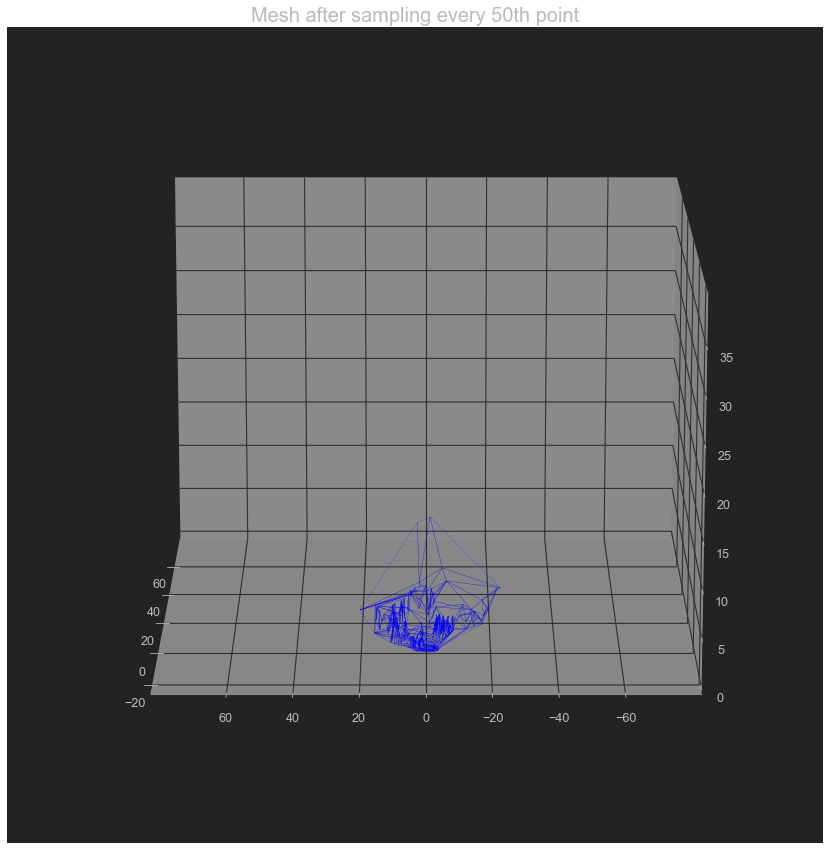

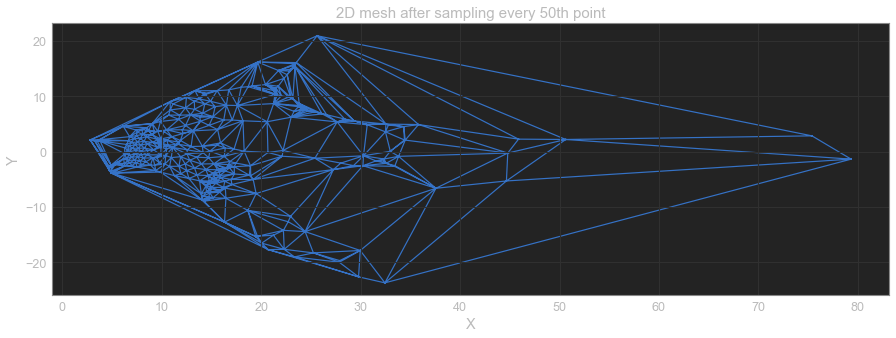

Large oversampling of points that are near the lidar. 
 Points further away are not represented as well.


In [39]:
sample_rate = 50
cropped_lidar_subsampled = cropped_lidar[::sample_rate]

cropped_triangles = dt.Delaunay(cropped_lidar_subsampled[:, :2])

tri_num = cropped_triangles.simplices.max() // 2
tmp = cropped_lidar_subsampled[cropped_triangles.simplices[tri_num]]

%matplotlib inline

fig = plt.figure(figsize=[15, 15])
# fig.tight_layout(pad=2)
ax = fig.add_subplot(1, 1, 1, projection='3d')
# Plot triangles
ax.plot_trisurf(cropped_lidar_subsampled[:, 0],
                cropped_lidar_subsampled[:, 1],
                cropped_lidar_subsampled[:, 2],
                color='none',
                edgecolor='blue',
                triangles=cropped_triangles.simplices)
# ax.plot_trisurf(tmp[:,0], tmp[:,1], tmp[:,2], color='red')#,triangles=[0,1,2])

ax_lims = [cropped_lidar_subsampled.min(), cropped_lidar_subsampled.max()]
ax.set_xlim(ax_lims)
ax.set_ylim([-cropped_lidar_subsampled.max(), cropped_lidar_subsampled.max()])
ax.set_zlim([0, cropped_lidar_subsampled.max() / 2])

ax.set_title(f"Mesh after sampling every {sample_rate}th point", fontsize=20)
ax.view_init(elev=15., azim=180)



fig_tri_2d = plt.figure(figsize=im_fig_size)
ax_tri_2d = fig_tri_2d.add_subplot(111)

ax_tri_2d.triplot(cropped_lidar_subsampled[:, 0],
                cropped_lidar_subsampled[:, 1],
#                 color='none',
#                 edgecolor='blue',
                triangles=cropped_triangles.simplices)

ax_tri_2d.set_xlabel("X")
ax_tri_2d.set_ylabel("Y")
ax_tri_2d.set_title(f"2D mesh after sampling every {sample_rate}th point", fontsize=im_fig_size[0])


plt.show()
print("Large oversampling of points that are near the lidar. \n Points further away are not represented as well.")


## Error Metrics
<br>
<br>
<br>


In [40]:
pts_all = pointcloud_to_img_frame(lidar_data, imgL.shape[0], imgL.shape[1], data.calib.T_cam2_velo, data.calib.P_rect_20)[:,:3]
pts_sampled = pts_all.copy()[::50]
mesh = dt.Delaunay(pts_sampled[:,:2])

### Euclidean distance to triangle plane
<br>
<br>
<br>

Finding the triangle containing the point. 

- If point in triangle:
    - Getting the Z height of the plane above the point

- if point outside all triangles:
    - get euclidean distance to nearest edge

- Get MSE for each triangle


In [41]:
# get containing triangles:
cont_tri = mesh.find_simplex(pts_all[:,:2])
cont_tri_vert = pts_sampled[mesh.simplices[cont_tri]]
print(cont_tri.shape)
print(cont_tri_vert.shape)
print(mesh.simplices.shape)

(18772,)
(18772, 3, 3)
(739, 3)


(376, 2)


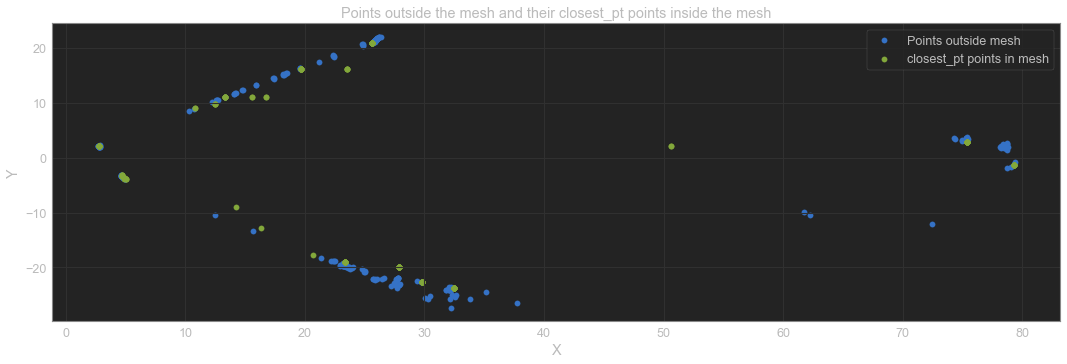

In [127]:
# Need to do something to find closest_pt verticies
print(mesh.points.shape)

# Distance to points:
inds = np.where(cont_tri<0)
test = pts_all[inds].copy()
# print(test[:3])
closest_pt = np.zeros((test.shape[0], mesh.points.shape[1]))
simps = np.zeros((test.shape[0], mesh.points.shape[1]))
for i,out in enumerate(test):
    dist = np.sum((mesh.points - out[:2])**2, axis=1)
    a_sort = np.argsort(dist)
    closest_pt[i] = mesh.points[a_sort[0]]
    simps[i] = mesh.find_simplex(closest_pt[i])
#     print(f"Ind: {np.argmin(dist)}, \tSimp: {simps[i]}")
#     print(f"closest_pt point is:{closest_pt[i]}")
    
fig_c, ax_c = plt.subplots(1,1,figsize=im_fig_size)
fig_c.tight_layout(pad=2)
ax_c.scatter(test[:,0], test[:,1], label= "Points outside mesh")
ax_c.scatter(closest_pt[:,0], closest_pt[:,1], label="closest_pt points in mesh")
ax_c.set_title("Points outside the mesh and their closest_pt points inside the mesh")
ax_c.legend(loc='best')
ax_c.set_xlabel("X")
ax_c.set_ylabel("Y")

plt.show()

Closest pt:  [ 23.3409996  -19.04400063]
Closest Simp:
 118


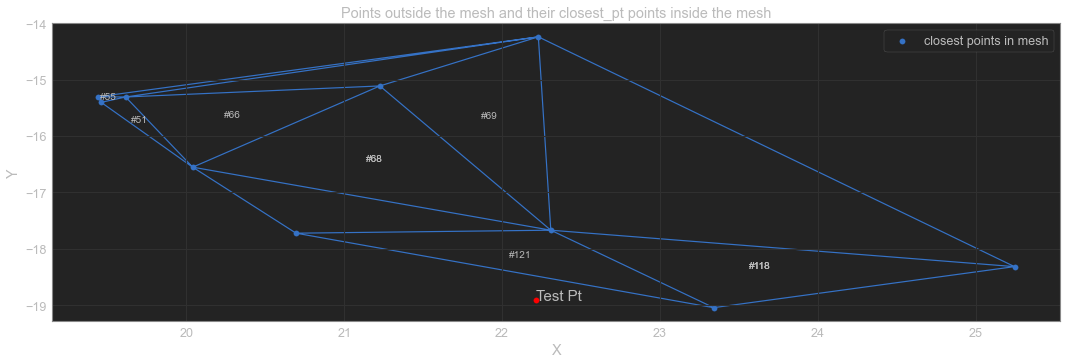

In [147]:
pt = test[1,:2]

dist = np.sum((mesh.points - test[1,:2])**2, axis=1)
c = mesh.points[dist.argsort()][:10]
cp = c[0]
# Sorted list of closest points
print("Closest pt: ", cp)
print("Closest Simp:\n",mesh.find_simplex(cp))

# print(mesh.simplices[0])
# print(mesh.simplices[1])
n = mesh.find_simplex(cp)
n = n[n>=0]
n_n = mesh.neighbors[n]



np.unique(mesh.simplices[mesh.find_simplex(c[:3])], axis=0) # Get unique triangles for three closest points




# NOTE:
    
# Will probably have to use centroids of triangles. 
# 106 is closer to point than 124 and yet triangle 0 is the closest. 



fig_close, ax_close = plt.subplots(1,1,figsize=im_fig_size)
fig_close.tight_layout(pad=2)

# ax_close.scatter(test[:,0], test[:,1], label= "Points outside mesh")
ax_close.scatter(c[:,0], c[:,1], label="closest points in mesh")

sim = mesh.find_simplex(c)
t = mesh.points[mesh.simplices[sim]]
# plt.triplot(d.points[:,0], d.points[:,1], d.simplices)
ax_close.triplot(t[:,:,0].flatten(), t[:,:,1].flatten())

for j, s in enumerate(t):
    p = s.mean(axis=0)
    ax_close.text(p[0], p[1], '#%d' %  sim[j], ha='center') # label dangles
    
    
ax_close.text(pt[0], pt[1], "Test Pt", ha="left", fontsize=im_fig_size[0])
ax_close.scatter(pt[0], pt[1], c="red")

ax_close.set_title("Points outside the mesh and their closest_pt points inside the mesh")
ax_close.legend(loc='best')
ax_close.set_xlabel("X")
ax_close.set_ylabel("Y")


plt.show()

Code to Find the closest triangles:

In [181]:
dist = np.sum((mesh.points - pt)**2, axis=1)
c = mesh.points[dist.argsort()][:10] # 10 closest points
c_tris = mesh.find_simplex(c) # closest triangles by simplex found from points 
c_centers = (mesh.points[mesh.simplices[sim]].sum(axis=1)/3) # centers
closest_tri = c_tris[np.sum((c_centers - pt)**2, axis=1).argmin()]


121

In [71]:
print(mesh.find_simplex(cp))
print(n_n)

print(mesh.simplices[n])

print(mesh.find_simplex(c[1]))
print(mesh.neighbors[mesh.find_simplex(c[1])])
print(mesh.simplices[mesh.find_simplex(c[1])])


118
[[117  56 121]]
[[115  60 106]]
56
[ 32  57 118]
[115 106  70]


In [109]:
points = mesh.points[mesh.find_simplex(c[:3])]
simplices = mesh.simplices[mesh.find_simplex(c[:3])]
print(simplices)
points = mesh.points[np.unique(simplices)]
# simplices = np.array([[]])

# tri = dt.Delaunay()
print()
print(points)
print()
print(simplices)


[[115  60 106]
 [115  60 106]
 [ 60 115 124]]

[[ 23.3409996  -19.04400063]
 [ 25.24699974 -18.31599998]
 [ 22.30900002 -17.67000008]
 [ 20.69499969 -17.72299957]]

[[115  60 106]
 [115  60 106]
 [ 60 115 124]]


Text(22.215999603271484, -18.91200065612793, 'Point')

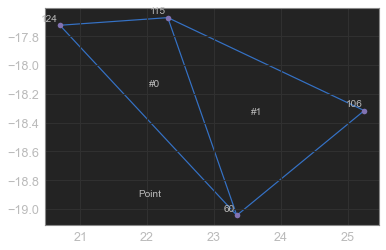

In [108]:
plt.triplot(d.points[:,0], d.points[:,1], d.simplices)
plt.triplot(points[:,0], points[:,1], 'o')

s = np.unique(simplices)
for j, p in enumerate(points):
    plt.text(p[0]-0.03, p[1]+0.03, s[j], ha='right') # label the points
for j, s in enumerate(d.simplices):
    p = points[s].mean(axis=0)
    plt.text(p[0], p[1], '#%d' %  j, ha='center') # label dangles
    
plt.plot(pt[0], pt[1])
plt.text(pt[0], pt[1], "Point", ha='right')

In [258]:
mesh.points[mesh.simplices[mesh.find_simplex(closest[1])]]

array([[ 69.18900299,  31.57099915],
       [ 66.8789978 ,  13.48200035],
       [ 72.41200256, -14.06000042]])

In [150]:
if cont_tri.min() <0:
    print(f"{np.sum(cont_tri==-1)} of {cont_tri.shape[0]} points found outside of mesh")
else:
    print("All points inside of mesh")

262 of 18772 points found outside of mesh


In [151]:
def get_general_barycentric(tri, pts):
    bcs = np.zeros((pts.shape[0], 3))
    for i in range(pts.shape[0]):                   
        pt = pts[i,:2]    
        t = tri.find_simplex(pt)
        b = tri.transform[t,:2].dot(np.transpose(pt.reshape((1,-1)) - tri.transform[t,2]))
        bcs[i] = np.c_[np.transpose(b), 1 - b.sum(axis=0)]
    return bcs



def get_z_error(mesh, mesh_pts, samples):
    bcs = get_general_barycentric(mesh, pts)
    
    


In [152]:
print(mesh.simplices.shape)
mesh.neighbors.shape

(739, 3)


(739, 3)

In [153]:
# print(pts_all[cont_tri[:10]])
pts_in = pts_all[cont_tri[cont_tri>=0]]


In [154]:
b = get_general_barycentric(mesh, pts_in)
b.shape

(18510, 3)

In [155]:
print(b[1].reshape(1,-1))
print()
print(cont_tri_vert[1])
# b[1].reshape(1,-1)

[[0.66486374 0.19407254 0.14106372]]

[[32.97900009  0.057       1.324     ]
 [34.40299988  2.10599995 -1.52699995]
 [32.49200058  3.5769999   1.10699999]]


In [202]:
# sample = cont_tri_vert[:4]@b[:4].reshape(4,3,1)
n = 2
v = cont_tri_vert[:n][:,:,:2]
c = b[:n].reshape(-1, 3,1)
# v.T.dot(c)
print(v)
print("V", v.shape)
print(c)
print("C",c.shape)
print("cT *v")
# print((c.T*v))
print("v*c")
print((v*c).astype(int))
print()
print((v*c).sum(axis=1))

sample=(v*c).sum(axis=1)

[[[58.54100037  1.86899996]
  [28.35199928 13.18200016]
  [46.52700043 13.53800011]]

 [[32.29600143 13.20699978]
  [58.54100037  1.86899996]
  [46.52700043 13.53800011]]]
V (2, 3, 2)
[[[-50.19013098]
  [112.10761345]
  [-60.91748247]]

 [[-50.56689623]
  [111.92780188]
  [-60.36090565]]]
C (2, 3, 1)
cT *v
v*c
[[[-2938   -93]
  [ 3178  1477]
  [-2834  -824]]

 [[-1633  -667]
  [ 6552   209]
  [-2808  -817]]]

[[-2594.01323294   559.29634162]
 [ 2110.8450547  -1275.80987746]]


In [106]:
# sample
print(cont_tri_vert[:2])
print()
print(cont_tri_vert[:2][:,:,1].flatten())
print(cont_tri_vert[:2][:,:,1].flatten())

[[[58.54100037  1.86899996  2.19000006]
  [28.35199928 13.18200016  1.26600003]
  [46.52700043 13.53800011  1.84800005]]

 [[32.29600143 13.20699978  1.38900006]
  [58.54100037  1.86899996  2.19000006]
  [46.52700043 13.53800011  1.84800005]]]

[ 1.86899996 13.18200016 13.53800011 13.20699978  1.86899996 13.53800011]


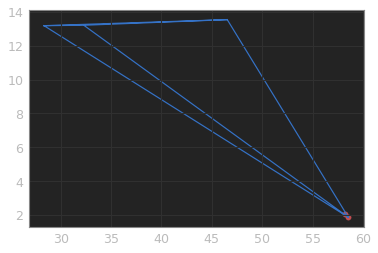

In [197]:
plt.figure()
plt.triplot(v[:,:,0].flatten(),v[:,:,1].flatten())
plt.scatter(sample[:,0], sample[:,1], color='r')#,cont_tri_vert[1][:,2])
plt.show()

### Hausdroff Error
<br>
<br>


See: http://www.cmap.polytechnique.fr/~peyre/cours/x2005signal/mesh_mesh.pdf
<br>
<br>


## Sampling the mesh
<br>
<br>
<br>
